- Filename: Eval-Speed_Plot-Fig2.ipynb
- Author: Siren Rühs (s.ruhs@uu.nl)
- Created: June 2023
- Last updated: Nov 14th 2024
- Description:
Jupyter notebook accompanying the manuscript "Non-negligible impact of Stokes drift and wave-driven Eulerian currents on simulated surface particle dispersal in the Mediterranean Sea" by Rühs et al., used to produce Figure 2

# Comparing gridded surface speed from ocean-only (uncoupled) and ocean-wave (coupled) model simulations for the Mediterranean Sea

# 1. General Settings

### 1.1 Load modules and check versions

In [1]:
from glob import glob

import numpy as np
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.offsetbox import AnchoredText
from matplotlib import cm

import utils
from utils import ColorSettings as cparams

In [2]:
utils.print_imported_package_versions(globals())

xarray==2022.12.0
matplotlib==3.6.2
numpy==1.24.1


### 1.2 Set input and output paths

In [3]:
datapath_orig = '../data-orig/'

datapath_proc = '../data-proc/'

outpath_figs = '../figs/'

gridpath = '../data-orig/'

maskpath = '../data-proc/domain/'

### 1.3 Define custom parameters

In [4]:
############################

plot_only = True
# If you run notebook for the first time, set plot_only to False,
# this will make sure that you calculate the averaged u and v fields and save them for later use 
# (as defined in section 3 below)
# Afterwards set plot_only to avoid re-computation of the avreages every time

############################

In [5]:
col_blue = cparams.blue
col_cyan = cparams.cyan
col_green = cparams.green
col_yellow = cparams.yellow
col_red = cparams.red
col_purple = cparams.purple
col_grey = cparams.grey

## 2. Loading Data

In [6]:
speed_tave_ds = xr.open_mfdataset(sorted(glob(datapath_proc + 'eul/speed/'
                                              + 'Speed-tave-fulldepth-z001.nc')),
                                              combine='nested', concat_dim='z')

In [7]:
grid = xr.open_dataset(
    gridpath + 'mesh_mask.nc', drop_variables=('x', 'y'))

Mask_MedSea_ds = xr.open_dataset(maskpath + 'Mask_MedSea.nc')
mask = Mask_MedSea_ds.Mask_MedSea


## 3. Calculating mean u and v on same grid

In [8]:
if plot_only == False:

    ### 1. Load data
    datapath_nc = datapath_orig + 'MedFS-IMMERSE-NEMO4p2-uncoupled_gridUV-z001/'
    datapath_c = datapath_orig + 'MedFS-IMMERSE-NEMO4p2-coupled_gridUV-z001/'
    uvars_ugrid_nc = xr.open_mfdataset(sorted(glob(datapath_nc + 'MED24_OBC_1d*_grid_U.nc')),
                                 chunks=None, combine='by_coords')
    vvars_vgrid_nc = xr.open_mfdataset(sorted(glob(datapath_nc + 'MED24_OBC_1d*_grid_V.nc')),
                                 chunks=None, combine='by_coords')
    uvars_ugrid_c = xr.open_mfdataset(sorted(glob(datapath_c + 'MED24_OBC_1d*_grid_U.nc')),
                                chunks=None, combine='by_coords')
    vvars_vgrid_c = xr.open_mfdataset(sorted(glob(datapath_c + 'MED24_OBC_1d*_grid_V.nc')),
                                chunks=None, combine='by_coords')
    uvars_ugrid_nc = uvars_ugrid_nc.squeeze(drop=True)
    vvars_vgrid_nc = vvars_vgrid_nc.squeeze(drop=True)
    uvars_ugrid_c = uvars_ugrid_c.squeeze(drop=True)
    vvars_vgrid_c = vvars_vgrid_c.squeeze(drop=True)
    
    ### 2. Get data on same grid (u-grid)
    ### Note: interpolation on same grid does not significantly change the results
    ### hence, a very simple interpolation is used here and in the speed calculation
    ### (see CalcSpeed[].py scripts)
    vvars_c = vvars_vgrid_c.interp_like(uvars_ugrid_c, method='linear')
    vvars_nc = vvars_vgrid_nc.interp_like(uvars_ugrid_nc, method='linear')
    uvars_c = uvars_ugrid_c
    uvars_nc = uvars_ugrid_nc

    ### 3. Retrieve u and v components
    u_Enc = uvars_nc.vozocrtx
    v_Enc = vvars_nc.vomecrty
    u_Ec = uvars_c.vozocrtx
    v_Ec = vvars_c.vomecrty 
    u_Sc = uvars_c.usd
    v_Sc = vvars_c.vsd

    ### 4. Calculate temporal averages
    u_Enc_tave = u_Enc.mean(dim='time_counter').compute()
    u_Ec_tave = u_Ec.mean(dim='time_counter').compute()
    u_Sc_tave = u_Sc.mean(dim='time_counter').compute()
    v_Enc_tave = v_Enc.mean(dim='time_counter').compute()
    v_Ec_tave = v_Ec.mean(dim='time_counter').compute()
    v_Sc_tave = v_Sc.mean(dim='time_counter').compute()
        
    ### 5. Save data
    u_tave_ds = xr.Dataset(data_vars = {'Enc': u_Enc_tave.where(u_Enc_tave !=0),
                                        'Ec': u_Ec_tave.where(u_Ec_tave !=0),
                                        'Sc': u_Sc_tave.where(u_Sc_tave !=0)})
    v_tave_ds = xr.Dataset(data_vars = {'Enc': v_Enc_tave.where(v_Enc_tave !=0),
                                        'Ec': v_Ec_tave.where(v_Ec_tave !=0),
                                        'Sc': v_Sc_tave.where(v_Sc_tave !=0)})
    u_tave_ds.to_netcdf(datapath_proc + 'eul/uv/U-tave-z001.nc')
    v_tave_ds.to_netcdf(datapath_proc + 'eul/uv/V-tave-z001.nc')

## 4. Visualization Figure 2

In [9]:
if plot_only == True:
    u_tave_ds = xr.open_dataset(datapath_proc + 'eul/uv/U-tave-z001.nc')
    v_tave_ds = xr.open_dataset(datapath_proc + 'eul/uv/V-tave-z001.nc')

In [10]:
# Define plotting parameters and custom functions

lonmin_plot = -7
lonmax_plot = 36
latmin_plot = 30.5
latmax_plot = 46
xticks = [0,10,20,30]
yticks = [35,40,45]
xticklabs = ['0°E','10°E','20°E', '30°E']
yticklabs = ['35°N','40°N','45°N']

lw_box = 0.8
fs='xx-small'

def plot_velmag(magnitude):
    map = plt.pcolor(magnitude.nav_lon, magnitude.nav_lat,
                     magnitude,
                     cmap=colm, norm=norm,
                     shading='nearest')
    return map

def plot_veldir(var1,var2,var3,lowspeed=False):
    ind_v = slice(0,380,10)
    ind_u = slice(0,1300,10)
    plt.quiver(var1.nav_lon.isel(x=ind_u, y=ind_v).where(var3.isel(x=ind_u, y=ind_v) >= speedlim),
           var1.nav_lat.isel(x=ind_u, y=ind_v).where(var3.isel(x=ind_u, y=ind_v) >= speedlim),
           var1.isel(x=ind_u, y=ind_v).where(var3.isel(x=ind_u, y=ind_v) >= speedlim),
           var2.isel(x=ind_u, y=ind_v).where(var3.isel(x=ind_u, y=ind_v) >= speedlim),
           angles='xy', scale_units='xy',
           color = 'whitesmoke',
           width = 0.002)
    if lowspeed == True:
        plt.quiver(var1.nav_lon.isel(x=ind_u, y=ind_v).where((var3.isel(x=ind_u, y=ind_v) < speedlim)),
                   var1.nav_lat.isel(x=ind_u, y=ind_v).where((var3.isel(x=ind_u, y=ind_v) < speedlim)),
                   var1.isel(x=ind_u, y=ind_v).where((var3.isel(x=ind_u, y=ind_v) < speedlim)),
                   var2.isel(x=ind_u, y=ind_v).where((var3.isel(x=ind_u, y=ind_v) < speedlim)),
                   angles='xy', scale_units='xy',
                   color='grey',
                   width = 0.001)
        
def build_subplot_velocity(magnitude,xticklabel=True,yticklabel=True):
    map = plot_velmag(magnitude)
    utils.plot_bathy(grid)
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    if xticklabel==False:
        ax.set_xticklabels([])
    else: 
        ax.set_xticklabels(xticklabs)
    if yticklabel==False:
        ax.set_yticklabels([])
    else:
        ax.set_yticklabels(yticklabs)
    ax.tick_params(axis='both', labelsize=fs)
    return map

/var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/ipykernel_29422/262281514.py:14: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  map = plt.pcolor(magnitude.nav_lon, magnitude.nav_lat,
/var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/ipykernel_29422/262281514.py:14: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  map = plt.pcolor(magnitude.nav_lon, magnitude.nav_lat,


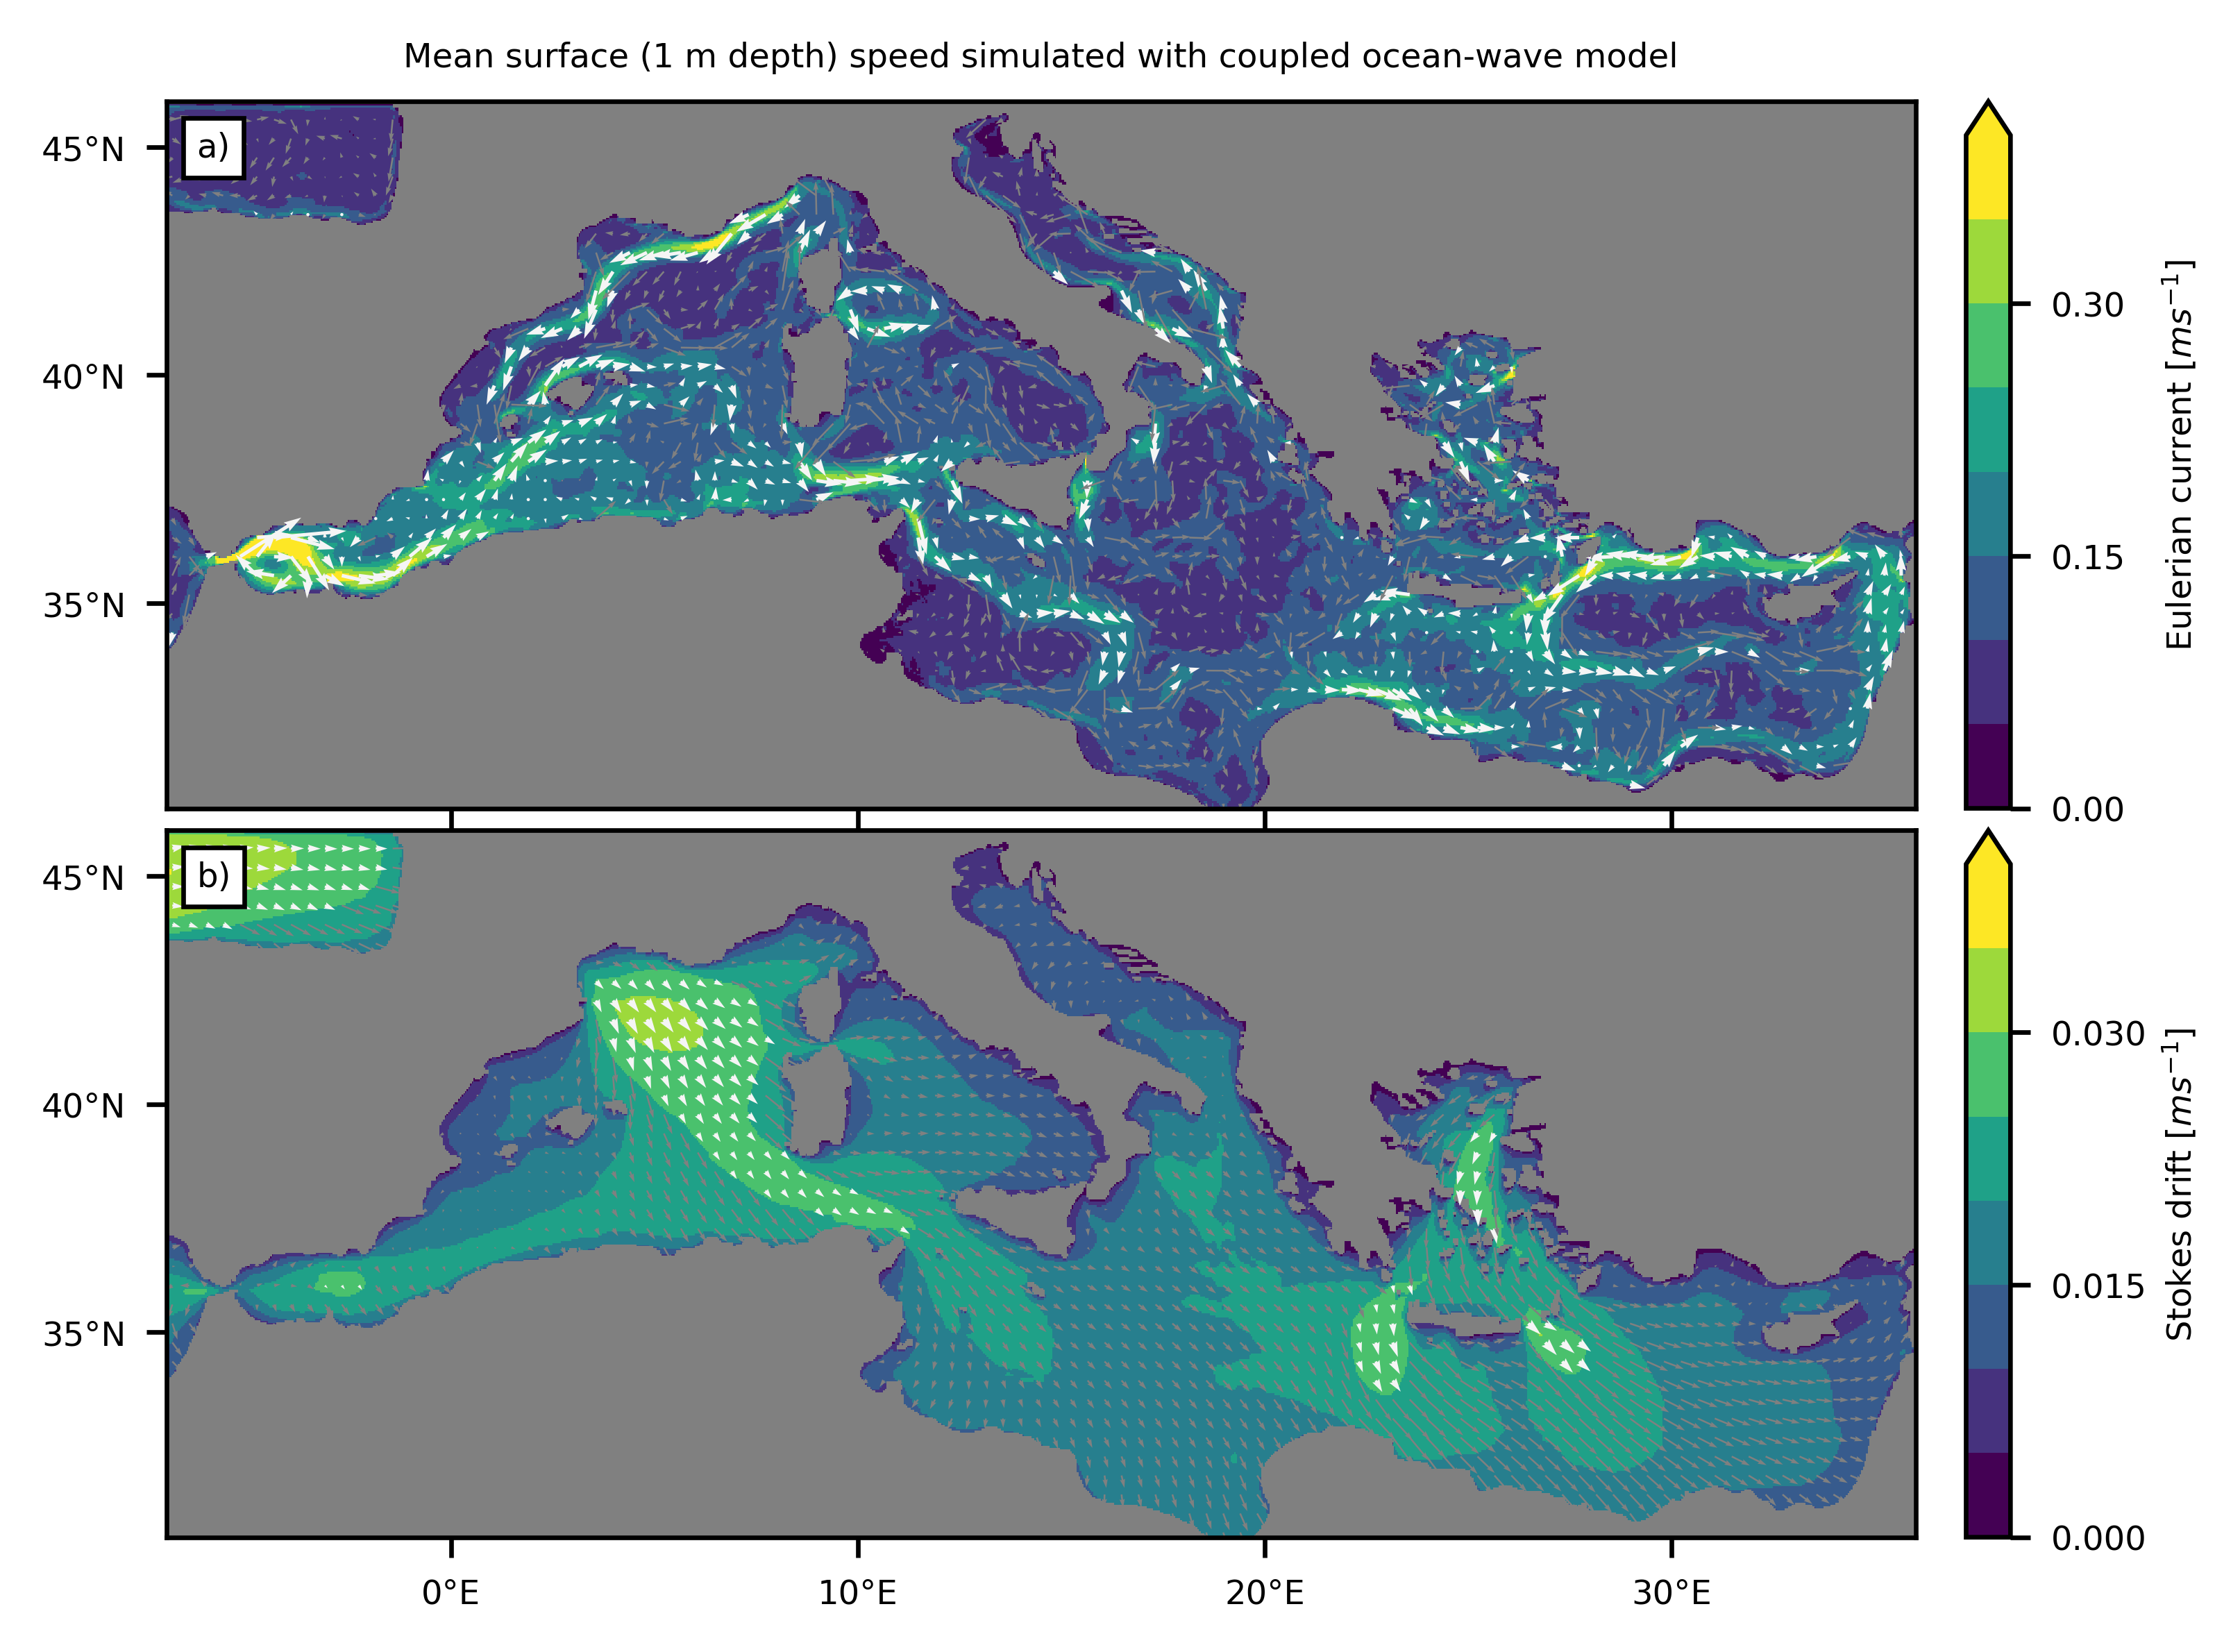

In [11]:
# Do the  plotting

fig = plt.figure(figsize=(6,6.75), dpi=600, constrained_layout=False)

gs2 = fig.add_gridspec(nrows=9, ncols=3, 
                       left=0.1, right=0.8,
                       wspace=0.03, hspace=0.1)
gscbar = fig.add_gridspec(nrows=9, ncols=100, 
                          left=0.1, right=1.0,
                          wspace=0.03, hspace=0.1)

ncticks_EC= [0, 0.15, 0.30] # ntics for colorbar
ncticks_SD= [0, 0.015, 0.030] 

ax = fig.add_subplot(gs2[0:3,0:3])
colm = cm.viridis 
levs = np.arange(0, 0.45, 0.05)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)
speedlim = 0.15
var1 = u_tave_ds.Ec
var2 = v_tave_ds.Ec
var3 = speed_tave_ds.Ec.isel(z=0)
map = build_subplot_velocity(var3, xticklabel=False, yticklabel=True)
plot_veldir(var1, var2, var3, lowspeed=True)
cbaxes = fig.add_subplot(gscbar[0:3,80:82])
cbar = plt.colorbar(map, cax = cbaxes, ticks=ncticks_EC,
                    orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
cbar.minorticks_off()
ax.text(42.5,latmin_plot+(latmax_plot-latmin_plot)/2,'Eulerian current [$m s^{-1}$]', rotation=90, va='center', ha='center', fontsize=fs)
ax.set_title('Mean surface (1 m depth) speed simulated with coupled ocean-wave model', fontsize=fs)
at = AnchoredText('a)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

ax = fig.add_subplot(gs2[3:6,0:3])
colm = cm.viridis 
levs = np.arange(0, 0.045, 0.005)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)
speedlim = 0.025
var1 = u_tave_ds.Sc
var2 = v_tave_ds.Sc
var3 = speed_tave_ds.Sc.isel(z=0)
map = build_subplot_velocity(var3, xticklabel=True, yticklabel=True)
plot_veldir(var1, var2, var3, lowspeed=True)
cbaxes = fig.add_subplot(gscbar[3:6,80:82])
cbar = plt.colorbar(map, cax = cbaxes, ticks=ncticks_SD,
                    orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
cbar.minorticks_off()
ax.text(42.5,latmin_plot+(latmax_plot-latmin_plot)/2,'Stokes drift [$m s^{-1}$]', rotation=90, va='center', ha='center', fontsize=fs)
at = AnchoredText('b)', prop=dict(size=fs), frameon=True, loc='upper left')
at.patch.set_linewidth(lw_box)
ax.add_artist(at)

In [ ]:
# Save the figure
fig.savefig('../figs/png/fig02.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
fig.savefig('../figs/png-transparent/fig02.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1,
            transparent=True)